In [1]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from scipy import signal
from glob import glob
from sklearn.linear_model import LinearRegression
from matplotlib import ticker, cm
import matplotlib.colors as colors
import datetime as dt
import scipy.ndimage

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#data direcgtory for temperature logger .csv files
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#data direcgtory for temperature logger .csv files
figs_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)

ModuleNotFoundError: No module named 'cartopy'

# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [2]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)

#read in temperature loggers
ds_log = xr.open_mfdataset(data_dir+'*1_minute-v1.nc',combine='nested',concat_dim='trajectory')
ds_log.close()


# read in satellite data

In [3]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [4]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    sdoy2 = str(t.timetuple().tm_yday).zfill(3)
    fname = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem.coords['lon'] = (tem.coords['lon'] + 180) % 360 - 180
tem = tem.sortby(tem.lon)
tem = tem.sel(lon=slice(-64,-46),lat=slice(4,16))
ds_rss = tem.load()

# read in ADCP data

In [5]:
dir_adcp = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/adcp/sd-1026/'
ds_adcp = xr.open_mfdataset(dir_adcp+'*.nc',combine='nested',concat_dim='obs')
ds_adcp.close()
ds_adcp=ds_adcp.isel(trajectory=0).swap_dims({'obs':'time'})
xlat=ds_adcp.latitude
xlon=ds_adcp.longitude
dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
dkm2=np.append(dkm2,dkm2[9214]) #add on last point
dkm3 = dkm2.cumsum()
ds_adcp['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_adcp.time})
ds_adcp['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_adcp.time})


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\array\core.py:1361: FutureWarning: The `numpy.append` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


# print eddy TS

3567.339265632886 4276.974209229797
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
[0.    0.166 0.332 0.498 0.664 0.83  0.996]


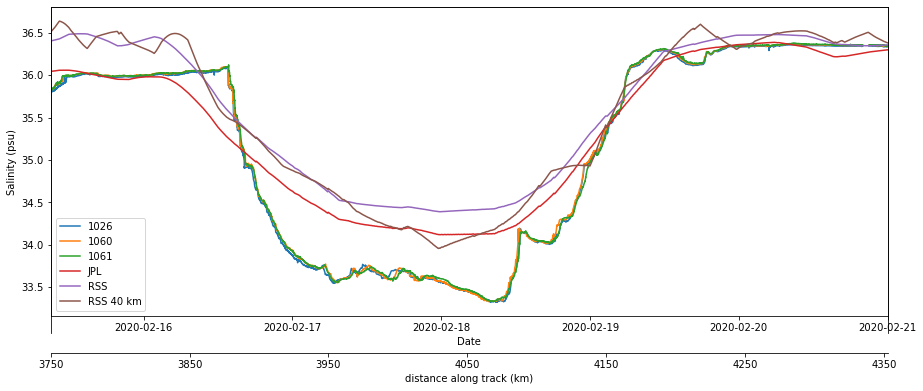

In [11]:
iusv=0
ds_usv = ds.isel(trajectory=iusv).sel(time=slice('2020-02-15T09','2020-02-21T0029'))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
t1,t2='2020-02-15T09','2020-02-21T00'
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
ds_usv = ds_jpl_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.smap_sss,label='JPL')
ds_usv = ds_rss_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.sss_smap,label='RSS')
ax0.plot(ds_usv.time,ds_usv.sss_smap_40km,label='RSS 40 km')
ax0.legend()
ax0.set_ylabel('Salinity (psu)')
ax0.set_xlabel('Date')
ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])

pos = ax0.get_position()
pos.y0 = pos.y0+.04       # for example 0.2, choose your value
ax0.set_position(pos)
#handles, labels = ax.get_legend_handles_labels()
#ax0.get_xticklabels(), ha="right", rotation=45)
ax2 = ax0.twiny()
# Add some extra space for the second axis at the bottom
#fig.subplots_adjust(bottom=0.2)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.06))
ax1Ticks = ax0.get_xticks()   
ax2Ticks = ax1Ticks
new_tick_locations = np.arange(0,1,0.166)
print(new_tick_locations)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(ll)
ax2.set_xlabel('distance along track (km)')
#labels = [item.get_text() for item in ax0.get_xticklabels()]
#ax0.set_xticklabels(labels,rotation=45) 
plt.savefig(figs_dir+'timeseries_eddy.png')
    

In [613]:
print(1/freq_usv[3],1/freq_usv[300])
#calculate max gradient
data_in = ds_saildrone
#make arrays for sampling at different length scales
length_scale = np.arange(.1,200,1)
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        if ilen2>3:
            continue
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)       
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        print(len2,max(den_grad))


1905.7333333333333 19.057333333333332
0.1 0.7677544716977991
1.1 0.3668732185952256
2.1 0.22945818643585253
3.1 0.18240483904792787
0.1 3.9200868094877706
1.1 0.3524936936445949
2.1 0.25303195164202036
3.1 0.17738343849974889
0.1 1.5272993758145503
1.1 0.289229112691487
2.1 0.2050854144292067
3.1 0.1654855241421897


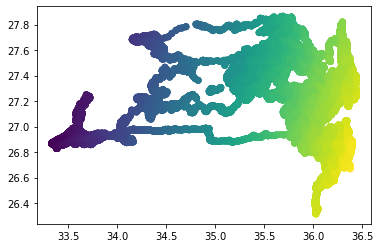

In [96]:
for iusv in range(3):
    plt.scatter(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,c=ds_usv.density_mean)


3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
3567.339265632886 4274.542512546288
[0.028638439698802618, 0.12418219972842859, 0.24416738674237748, 0.43895815331440563, 0.6268361930625849, 0.7585483273669917, 0.9003826688063202]


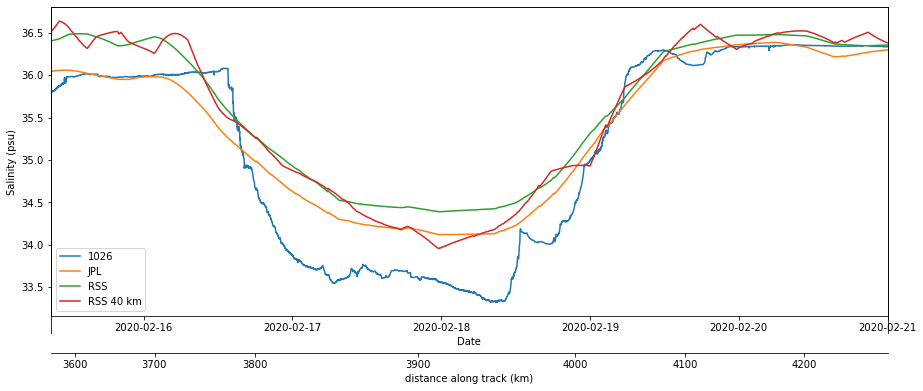

In [181]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
3567.339265632886 4274.542512546288
[0.028638439698802618, 0.12418219972842859, 0.24416738674237748, 0.43895815331440563, 0.6268361930625849, 0.7585483273669917, 0.9003826688063202]


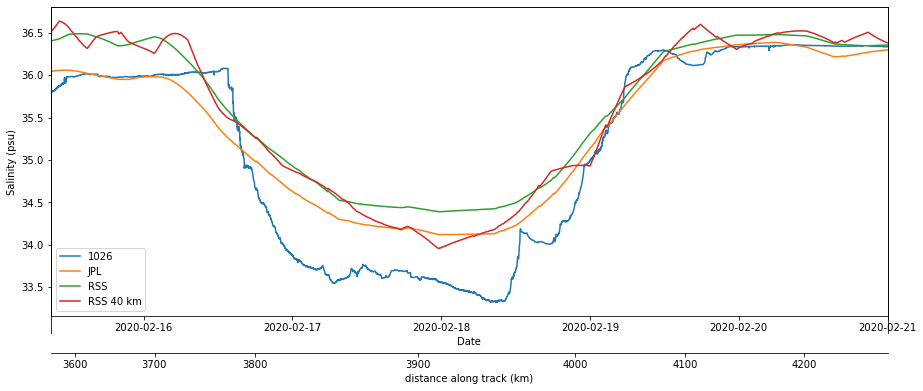

In [421]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    #plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)

3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))


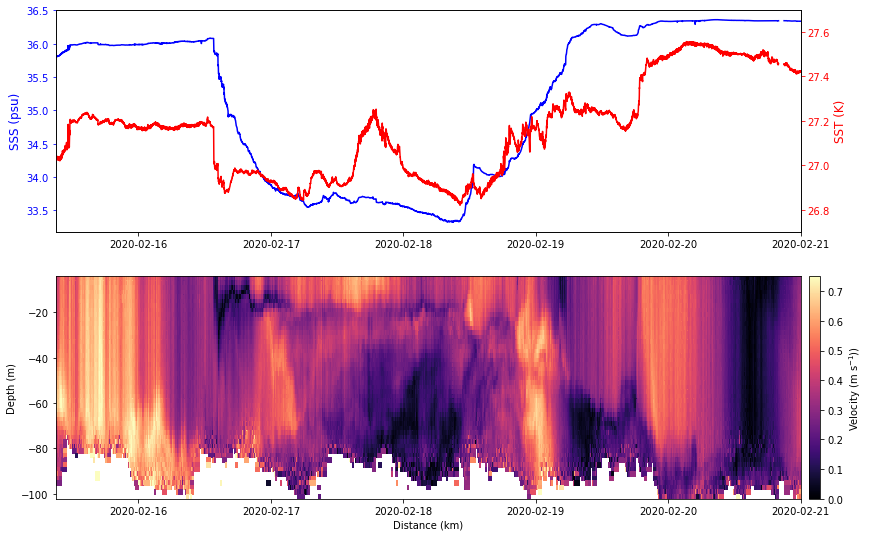

In [173]:

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
#ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)
#tem=ds_saildrone.sel(time=slice(t1,t2))

#tem = ds_adcp.sel(time=slice(t1,t2))
import math
iusv=0
 
ds_usv = ds_saildrone.isel(trajectory=iusv).sel(time=slice(t1,t2))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(axs)= plt.subplots(2,1,figsize=(15,9))
ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
ax0=axs[0]
ax0.plot(ds_usv.time,ds_usv[var1],'b',label=var1)
ax0.set_xlim([t1,t2])

ds_tem = ds_adcp.sel(time=slice(t1,t2))
#rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
#rx = rx[::15]
#ry=np.ones(len(rx))*31.5
#dx,dy = ds_tem.vel_east[::15,0], ds_tem.vel_north[::15,0]
#ax0.quiver(rx,ry,dx,dy,scale=10)

#rx = ds_usv.dist_total
#rx = rx[::85]
#ry=np.ones(len(rx))*37.5
#dx,dy = ds_usv.UWND_MEAN[::85], ds_usv.VWND_MEAN[::85]
#ax0.quiver(rx,ry,dx,dy,scale=170,color='g')

#add scale arrow
#ax0.quiver(ds_usv.dist_total[0],31.8,1,0,scale=10)
#ax0.text(ds_usv.dist_total[0],32,'1 m/s')
#ax0.set_ylim([31,38])

ax0a=ax0.twinx()
ax0a.plot(ds_usv.time,ds_usv.TEMP_SBE37_MEAN,'r',label='SST')
#ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_AIR_MEAN,'r',label='Air')
ax0a.set_xlim([t1,t2])
ax0a.set_ylim([26.7,27.7])
ax0a.set_ylabel('SST (K)',color='r',fontsize=12)
ax0a.tick_params(axis='y', colors='red')
ax0.set_ylabel('SSS (psu)',color='b',fontsize=12)
ax0.tick_params(axis='y', colors='b')
gg=ax0.get_position()

ax1=axs[1]
#ds_tem = ds_adcp.sel(time=slice(t1,t2))
ds_tem['cspd']=np.sqrt(ds_tem.vel_east**2+ds_tem.vel_north**2)
rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
ss = ds_tem.cspd.where(ds_tem.error_vel<.05)
ca = ax1.pcolormesh(ds_tem.time,-1*ds_tem.cell_depth,ss.transpose(),vmin=0,vmax=.75,cmap='magma')
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Distance (km)')
cc = fig.colorbar(ca, ax=ax1,label='Velocity (m s$^{-1})$)',pad=0.01,orientation='vertical',fraction=.1)
#make top figure same width
g1 = ax1.get_position()
gg.x1=g1.x1
ax0.set_position(gg)



2891.699292800347 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))


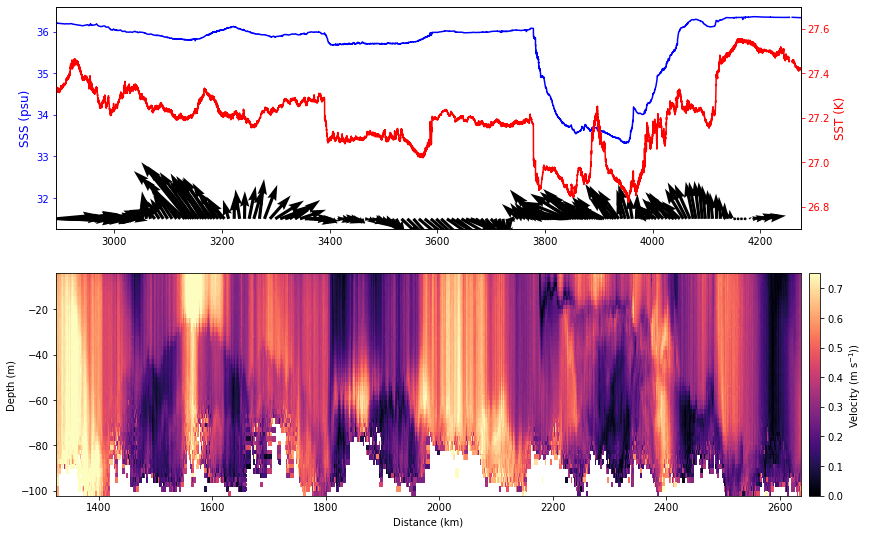

In [182]:

t1,t2 = np.datetime64('2020-02-10T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
#ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)
#tem=ds_saildrone.sel(time=slice(t1,t2))

#tem = ds_adcp.sel(time=slice(t1,t2))
import math
iusv=0
 
ds_usv = ds_saildrone.isel(trajectory=iusv).sel(time=slice(t1,t2))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(axs)= plt.subplots(2,1,figsize=(15,9))
ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
ax0=axs[0]
ax0.plot(ds_usv.dist_total,ds_usv[var1],'b',label=var1)
ax0.set_xlim([ds_usv.dist_total[0],ds_usv.dist_total[-1]])

ds_tem = ds_adcp.sel(time=slice(t1,t2))
rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
rx = rx[::15]
ry=np.ones(len(rx))*31.5
dx,dy = ds_tem.vel_east[::15,0], ds_tem.vel_north[::15,0]
ax0.quiver(rx,ry,dx,dy,scale=10)
ax0.set_xlim([ds_usv.dist_total[0],ds_usv.dist_total[-1]])

#rx = ds_usv.dist_total
#rx = rx[::85]
#ry=np.ones(len(rx))*37.5
#dx,dy = ds_usv.UWND_MEAN[::85], ds_usv.VWND_MEAN[::85]
#ax0.quiver(rx,ry,dx,dy,scale=170,color='g')

#add scale arrow
#ax0.quiver(ds_usv.dist_total[0],31.8,1,0,scale=10)
#ax0.text(ds_usv.dist_total[0],32,'1 m/s')
#ax0.set_ylim([31,38])

ax0a=ax0.twinx()
ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_SBE37_MEAN,'r',label='SST')
#ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_AIR_MEAN,'r',label='Air')
#ax0a.set_xlim([t1,t2])
ax0a.set_ylim([26.7,27.7])
ax0a.set_ylabel('SST (K)',color='r',fontsize=12)
ax0a.tick_params(axis='y', colors='red')
ax0.set_ylabel('SSS (psu)',color='b',fontsize=12)
ax0.tick_params(axis='y', colors='b')
ax0a.set_xlim([ds_usv.dist_total[0],ds_usv.dist_total[-1]])

gg=ax0.get_position()

ax1=axs[1]
#ds_tem = ds_adcp.sel(time=slice(t1,t2))
ds_tem['cspd']=np.sqrt(ds_tem.vel_east**2+ds_tem.vel_north**2)
rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
ss = ds_tem.cspd.where(ds_tem.error_vel<.05)
ca = ax1.pcolormesh(ds_tem.dist_total,-1*ds_tem.cell_depth,ss.transpose(),vmin=0,vmax=.75,cmap='magma')
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Distance (km)')
cc = fig.colorbar(ca, ax=ax1,label='Velocity (m s$^{-1})$)',pad=0.01,orientation='vertical',fraction=.1)
#make top figure same width
g1 = ax1.get_position()
gg.x1=g1.x1
ax0.set_position(gg)



In [98]:
ss2[0,:,:]

array([[0.00779615, 0.02592678, 0.01533647, ...,        nan,        nan,
               nan],
       [0.01936341, 0.02189498, 0.01621841, ...,        nan,        nan,
               nan],
       [0.02388994, 0.0112199 , 0.02241958, ...,        nan,        nan,
               nan],
       ...,
       [0.00359676, 0.00079893, 0.00295021, ..., 0.13816515, 0.00907524,
               nan],
       [0.00252217, 0.0079072 , 0.00645133, ...,        nan, 0.15064641,
               nan],
       [0.01341026, 0.00699234, 0.00709019, ...,        nan, 0.3194433 ,
               nan]])